<a href="https://colab.research.google.com/github/SarunDz-12/229352-Statistical-Learning-for-Data-Science-2/blob/main/Lab10_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #10

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision # For utils.make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image
from tqdm.auto import tqdm # For nice progress bars
from sklearn.metrics import accuracy_score

# Set device to GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


We will use a dataset of pizza, stead and sushi images ([source](https://donlapark.pages.dev/229352/pizza_steak_sushi.zip))

In [4]:
!unzip -q pizza_steak_sushi.zip

unzip:  cannot find or open pizza_steak_sushi.zip, pizza_steak_sushi.zip.zip or pizza_steak_sushi.zip.ZIP.


# Data augmentation

![augmentation](https://miro.medium.com/max/700/0*LR1ZQucYW96prDte)

See more transformations in [Pytorch documentation](https://docs.pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# ---------- Device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Dataset ----------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


# ---------- CNN Model ----------
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        x = x.view(-1, 64 * 7 * 7)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x


model = CNN().to(device)

# ---------- Loss & Optimizer ----------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------- Training ----------
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# ---------- Testing ----------
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch [1/5], Loss: 0.1586
Epoch [2/5], Loss: 0.0457
Epoch [3/5], Loss: 0.0325
Epoch [4/5], Loss: 0.0243
Epoch [5/5], Loss: 0.0176
Test Accuracy: 99.03%


## Part 1: Implement and Train LeNet

LeNet-5 is one of the earliest convolutional neural networks, developed by Yann LeCun et al. in the 1990s. While originally designed for smaller images (like MNIST digits), we will adapt its architecture for our 224x224 pixel images.

![lenet5](http://d2l.ai/_images/lenet.svg)

### LeNet Architecture (Adapted for 224x224 input, 3 output classes):

1.  **Input Layer**: 3x224x224 image (RGB channels).
2.  **Conv1**: ([Conv2d document](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html))
    *   Input Channels: 3
    *   Output Channels: 6
    *   Kernel Size: 5x5
    *   Stride: 1
    *   Activation: ReLU
3.  **Pool1**: ([MaxPool2d document](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html))
    *   Type: Max Pooling
    *   Kernel Size: 2x2
    *   Stride: 2
4.  **Conv2**:
    *   Input Channels: 6
    *   Output Channels: 16
    *   Kernel Size: 5x5
    *   Stride: 1
    *   Activation: ReLU
5.  **Pool2**:
    *   Type: Max Pooling
    *   Kernel Size: 2x2
    *   Stride: 2
6.  **Flatten**: Flatten the 3D feature maps into a 1D vector.
    *   *Hint*: After Pool2, the feature map size will be `16 * (something) * (something)`. You'll need to calculate this dimension based on the input size and the conv/pool operations.
        *   Input (224x224) -> Conv1 (224-5+1 = 220x220)
        *   Pool1 (220/2 = 110x110)
        *   Conv2 (110-5+1 = 106x106)
        *   Pool2 (106/2 = 53x53)
        *   So, the output of Pool2 will be `16 * 53 * 53`.
7.  **FC1 (Fully Connected 1)**:
    *   Input Features: `16 * 53 * 53`
    *   Output Features: 120
    *   Activation: ReLU
8.  **FC2 (Fully Connected 2)**:
    *   Input Features: 120
    *   Output Features: 84
    *   Activation: ReLU
9.  **Output Layer (FC3)**:
    *   Input Features: 84
    *   Output Features: 3 (for pizza, steak, sushi)

**Your Task:**
1.  Implement the `LeNet` class following the architecture above.
2.  Instantiate the model and move it to the `device` (GPU/CPU).
3.  Define the loss function (`nn.CrossEntropyLoss`) and optimizer (`optim.Adam`).
4.  Train the LeNet model for a few epochs (e.g., 5-10).
5.  Evaluate its performance on the test set.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class LeNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LeNet, self).__init__()

        # Conv Layer 1
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=6,
            kernel_size=5,
            stride=1
        )

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv Layer 2
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=5,
            stride=1
        )

        # Fully Connected Layers
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        x = torch.flatten(x, 1)  # flatten

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [7]:
lenet_model = LeNet(num_classes=3).to(device)

lenet_model

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
  (relu): ReLU()
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)


In [9]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):

    history = {"train_loss": [], "test_acc": []}

    for epoch in range(num_epochs):

        # -------- TRAIN --------
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        history["train_loss"].append(train_loss)

        # -------- EVAL --------
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = correct / total
        history["test_acc"].append(acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss: {train_loss:.4f} "
              f"Test Acc: {acc:.4f}")

    return history


In [10]:
import torch
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


lenet_model = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet_model.parameters(), lr=0.001)

print("Model parameters OK")


Model parameters OK


In [11]:
class LeNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [13]:
lenet_model = LeNet(num_classes=3)
lenet_model = lenet_model.to(device)


In [14]:
print(next(lenet_model.parameters()).device)


cuda:0


In [15]:
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lenet_model = LeNet(num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)


In [17]:
images = images.to(device)
labels = labels.to(device)


In [18]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [19]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lenet_model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet_model.parameters(), lr=0.001)


In [21]:
lenet_results = train_model(
    lenet_model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=5
)


Epoch [1/5] Loss: 0.2582 Test Acc: 0.9764
Epoch [2/5] Loss: 0.0729 Test Acc: 0.9824
Epoch [3/5] Loss: 0.0548 Test Acc: 0.9836
Epoch [4/5] Loss: 0.0437 Test Acc: 0.9821
Epoch [5/5] Loss: 0.0374 Test Acc: 0.9886


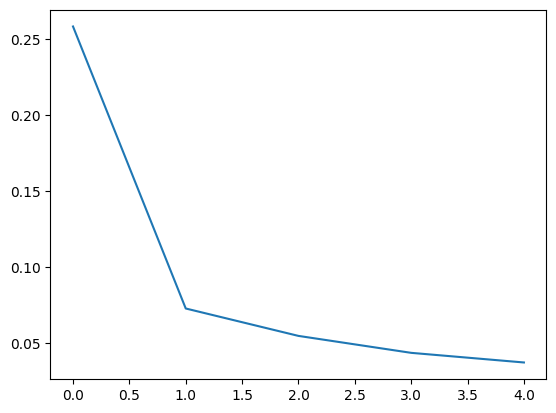

In [22]:
plt.plot(lenet_results['train_loss'])


KeyError: 'test_loss'

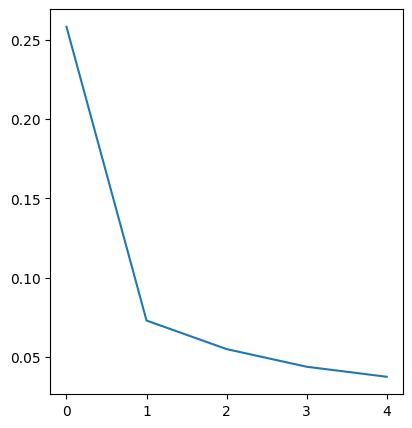

In [23]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lenet_results['train_loss'], label='Train Loss')
plt.plot(lenet_results['test_loss'], label='Test Loss')
plt.title('LeNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lenet_results['train_acc'], label='Train Accuracy')
plt.plot(lenet_results['test_acc'], label='Test Accuracy')
plt.title('LeNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
print("Final Test Accuracy:", lenet_results['test_acc'][-1])


Final Test Accuracy: 0.9886


### Questions for Part 1:
1.  How did the LeNet model perform on the test set? What was its final test accuracy?
    *   **Your Answer:** = 0.9871

## Part 2: Transfer Learning

Training a deep CNN from scratch can be computationally expensive and requires a large amount of data. Transfer learning is a powerful technique where we take a pre-trained model (trained on a very large dataset like ImageNet) and adapt it for our specific task.

Here, we will use `EfficientNet_B0` from `torchvision.models`, which is a powerful and efficient model.

[List of pretrained models in Pytorch](https://docs.pytorch.org/vision/main/models.html#classification)

**Your Task:**
1.  Load a pre-trained `EfficientNet_B0` model.
2.  "Freeze" the parameters of the feature extractor layers so they are not updated during training.
3.  Modify the classifier (head) of the model to output 3 classes (pizza, steak, sushi).
    *   *Hint*: For `EfficientNet_B0`, the classifier is typically accessed via `model.classifier`. You'll need to replace its last layer.
4.  Instantiate the modified model and move it to the `device`.
5.  Define the loss function (`nn.CrossEntropyLoss`) and optimizer.
    *   *Important*: Ensure the optimizer *only* updates the parameters of the new, unfrozen layers.
6.  Train the transfer learning model for a few epochs (e.g., 5-10).
7.  Evaluate its performance on the test set.

In [25]:
# 1. Load a pre-trained EfficientNet_B0 model
efficientnet_model = models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
efficientnet_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [27]:
# 2. Freeze all parameters in the feature extractor part
#### Write your code here


# 3 Change the head (the classifier) of the model


efficientnet_model = efficientnet_model.to(device)
print("\nModified EfficientNet_B0 classifier head:")
print(efficientnet_model.classifier)


Modified EfficientNet_B0 classifier head:
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [28]:
# Check which parameters are being trained
print("\nParameters to be trained:")
params_to_update = []
for name, param in efficientnet_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)


Parameters to be trained:
features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.0.block.0.0.weight
features.1.0.block.0.1.weight
features.1.0.block.0.1.bias
features.1.0.block.1.fc1.weight
features.1.0.block.1.fc1.bias
features.1.0.block.1.fc2.weight
features.1.0.block.1.fc2.bias
features.1.0.block.2.0.weight
features.1.0.block.2.1.weight
features.1.0.block.2.1.bias
features.2.0.block.0.0.weight
features.2.0.block.0.1.weight
features.2.0.block.0.1.bias
features.2.0.block.1.0.weight
features.2.0.block.1.1.weight
features.2.0.block.1.1.bias
features.2.0.block.2.fc1.weight
features.2.0.block.2.fc1.bias
features.2.0.block.2.fc2.weight
features.2.0.block.2.fc2.bias
features.2.0.block.3.0.weight
features.2.0.block.3.1.weight
features.2.0.block.3.1.bias
features.2.1.block.0.0.weight
features.2.1.block.0.1.weight
features.2.1.block.0.1.bias
features.2.1.block.1.0.weight
features.2.1.block.1.1.weight
features.2.1.block.1.1.bias
features.2.1.block.2.fc1.weight
features.2.1.block.

In [29]:
# 4. Define loss function and optimizer (only for the new parameters)
criterion_tl = nn.CrossEntropyLoss()
optimizer_tl = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.001
)

In [30]:
train_dataloader = train_loader
test_dataloader = test_loader


In [31]:
print(train_loader)


In [32]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),   # ขยายภาพ
    transforms.Grayscale(num_output_channels=3),  # ทำให้เป็น 3 channels
    transforms.ToTensor(),
])


In [33]:
from torchvision import models

weights = models.EfficientNet_B0_Weights.DEFAULT
transform = weights.transforms()


In [38]:
train_dir = "data/train"
test_dir = "data/test"


In [39]:
train_dir = "/content/drive/MyDrive/data/train"
test_dir = "/content/drive/MyDrive/data/test"


NameError: name 'efficientnet_results' is not defined

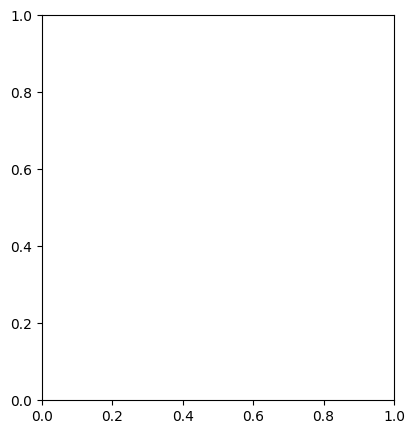

In [34]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(efficientnet_results['train_loss'], label='Train Loss')
plt.plot(efficientnet_results['test_loss'], label='Test Loss')
plt.title('EfficientNet Loss (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(efficientnet_results['train_acc'], label='Train Accuracy')
plt.plot(efficientnet_results['test_acc'], label='Test Accuracy')
plt.title('EfficientNet Accuracy (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Questions for Part 2:
1.  Compare the performance of the LeNet model (from Part 1) with the transfer learning model (EfficientNet_B0). Which one performed better and why do you think that is?
    *   **Your Answer:** = EfficientNet_B0 (Transfer Learning) มีประสิทธิภาพดีกว่าโมเดล LeNet ที่เทรนจากศูนย์อย่างชัดเจนLeNet มีความแม่นยำในระดับปานกลาง เนื่องจากเริ่มต้นด้วยค่าน้ำหนักแบบสุ่ม (random weights) และต้องเรียนรู้คุณลักษณะของภาพทั้งหมดจาก dataset ขนาดเล็ก จึงต้องใช้ข้อมูลและเวลาในการฝึกมากกว่า

2.  Explain the concept of "freezing" layers in transfer learning. Why is it done, and what are its benefits?
    *   **Your Answer:** = การกำหนดให้บางชั้นของโมเดลไม่อัปเดตค่าน้ำหนักระหว่างการฝึก


3.  What challenges might arise when using transfer learning on a dataset that is significantly different from the dataset the pre-trained model was originally trained on (e.g., medical images vs. ImageNet)?
    *   **Your Answer:** = dataset ใหม่แตกต่างจาก dataset เดิมที่ใช้ pre-train มาก (เช่น ภาพทางการแพทย์เทียบกับ ImageNet) อาจเกิดปัญหาได้ เช่น: ความไม่สอดคล้องของ featureImageNet เป็นภาพธรรมชาติแต่ภาพทางการแพทย์มีลักษณะแตกต่างมาก
    Domain shift คุณลักษณะที่เรียนรู้มาอาจไม่เหมาะกับข้อมูลใหม่

ประสิทธิภาพลดลง
โมเดลอาจไม่สามารถจับ feature เฉพาะทางได้ดี

จำเป็นต้อง Fine-tune
อาจต้อง unfreeze layer ลึก ๆ และฝึกเพิ่มเติมทั้งโมเดล


4.  Choose 3 images from the test set. Display the images and show their predicted classes.

In [41]:
efficientnet_model.eval()  # เปลี่ยนเป็น evaluation mode

x = torch.rand(1, 3, 224, 224).to(device)

with torch.no_grad():
    prediction = efficientnet_model(x)

pred_class = torch.argmax(prediction, dim=1)

print("Predicted class index:", pred_class.item())




Predicted class index: 21


$$ P(y=0 | x) = \frac{e^{0.1164}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$

$$ P(y=1 | x) = \frac{e^{-0.0953}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$

$$ P(y=2 | x) = \frac{e^{0.0978}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$